In [175]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [176]:
import statsmodels.api as sm

In [177]:
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score
from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold



%matplotlib inline


In [178]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'

In [180]:
df = pd.read_csv(os.path.join(basepath,'data','matched111724_centered_dum.csv'))  

In [181]:
# Get number of subjects
n = df.shape[0]

In [182]:
n

3700

In [183]:
list(df.columns)

['collection_id',
 'abcd_mx01_id',
 'dataset_id',
 'subjectkey',
 'src_subject_id',
 'demo_comb_income_v2',
 'bkfs_soda',
 'interview_age',
 'anthroheightcalc',
 'rsfmri_c_ngd_ad_ngd_ad',
 'rsfmri_c_ngd_ad_ngd_cgc',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_c_ngd_ca_ngd_dt',

In [190]:
nonBrain = [list(df.columns)[5], list(df.columns)[7] , list(df.columns)[-19],list(df.columns)[-15]]

In [191]:
nonBrain 

['demo_comb_income_v2', 'interview_age', 'bmi_perc', 'sex_M']

In [193]:
ROIs = list(df.columns)[11:-23]

In [194]:
ROIS = nonBrain+ROIs

In [195]:
list(ROIS)

['demo_comb_income_v2',
 'interview_age',
 'bmi_perc',
 'sex_M',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_c_ngd_ca_ngd_dt',
 'rsfmri_c_ngd_ca_ngd_dla',
 'rsfmri_c_ngd_ca_ngd_fo',
 'rsfmri_c_ngd_ca_ngd_n',
 'rsfmri_c_ngd_ca_ngd_rspltp',
 'rsfmri_c_ngd_ca_ngd_smh',
 'rsfmri_c

In [ ]:
#df['sex'] = df['sex'].replace({'M':0,'F':1})

In [196]:
df['ssb_group'] = df['ssb_group'].replace({'low':0,'high':1})

In [197]:
X = df[ROIS] #features

In [198]:
X.shape

(3700, 418)

In [199]:
# Transpose the DataFrame to make columns become rows
X_T = X.T

duplicates = X_T.duplicated(keep='first')


In [200]:
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index


In [201]:
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

      demo_comb_income_v2  interview_age  bmi_perc  sex_M  \
0                1.134865       2.208108 -0.074089      1   
1                1.134865      -3.791892 -0.166220      0   
2               -6.865135       2.208108 -0.117158      1   
3                0.134865      -0.791892  0.181997      0   
4               -3.865135      -0.791892  0.132754      0   
...                   ...            ...       ...    ...   
3695             0.134865       6.208108 -0.089739      1   
3696             1.134865      11.208108 -0.092898      0   
3697            -0.865135      -4.791892  0.209150      0   
3698             2.134865      12.208108  0.009343      1   
3699             1.134865       5.208108  0.314276      1   

      rsfmri_c_ngd_ad_ngd_ca  rsfmri_c_ngd_ad_ngd_dt  rsfmri_c_ngd_ad_ngd_dla  \
0                   0.043602               -0.052279                -0.001817   
1                   0.017131                0.052089                 0.004709   
2                   0.01

In [202]:
X.shape

(3700, 418)

In [203]:
X_cleaned.shape

(3700, 341)

# Factor of interest
This is sometimes called the target. Right now I am using sex, but eventually we will change this to SSB group

In [204]:
y = df['ssb_group'] #target

In [205]:
y.value_counts()

1    1850
0    1850
Name: ssb_group, dtype: int64

# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [207]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)


In [208]:
X_test.shape

(925, 341)

In [209]:
y_test.value_counts()

0    481
1    444
Name: ssb_group, dtype: int64

In [210]:
X_train.shape

(2775, 341)

In [211]:
X_train1.shape

(2081, 341)

In [212]:
y_train2.shape

(694,)

In [213]:
anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60],  # Trying different numbers of top features
    'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('anova', SelectKBest()),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=4,
             param_grid={'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                                      60],
                         'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                                    0.12, 0.13, 0.14, 0.15]})

In [ ]:
range(49)

In [ ]:
bestK = []
bestC = []
for i in range(49):
    print(i)
    # Setup GridSearchCV
    grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
    grid_search.fit(X_train1, y_train1)
    bestK.append(grid_search.best_params_['anova__k'])
    bestC.append(grid_search.best_params_['svc__C'])

## Initial
* anova_initial = [10,20,30,40,50,60]
* svc_C_initial = [0.1, 1, 10, 100]
* Then narrowed to anova 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60
* svc c 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15
## First try
* Best parameters: {'anova__k': 51, 'svc__C': 0.15}
* Best cross-validation score: 0.5530157342657344## Second try
## 48 iterations 
* Best parameters: {'anova__k': 50, 'svc__C': 0.05}
* Best cross-validation score: 0.7112026131762974

In [214]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'anova__k': 50, 'svc__C': 0.05}
Best cross-validation score: 0.7112026131762974


In [215]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])

In [216]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.7348703170028819


In [217]:
from sklearn.metrics import confusion_matrix

In [218]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

[[0.87215909 0.12784091]
 [0.40643275 0.59356725]]


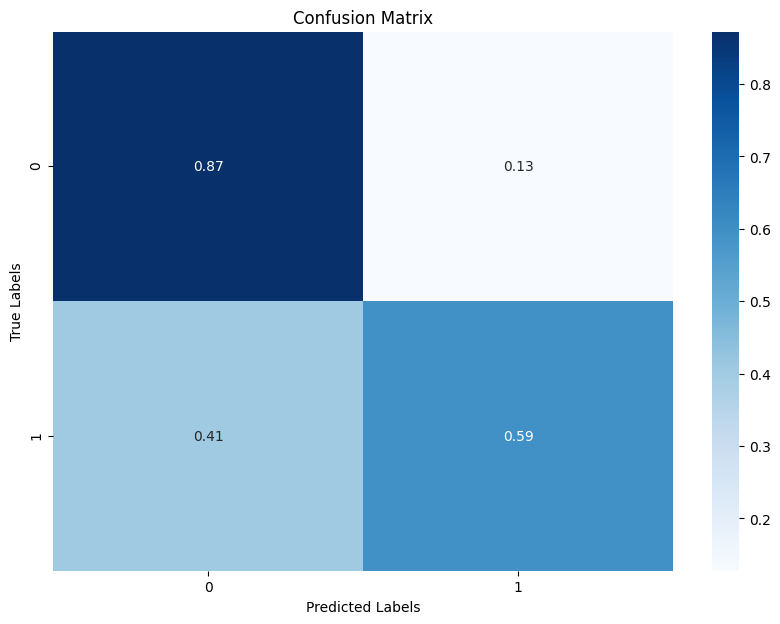

In [219]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [220]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


Best parameters found by GridSearchCV: {'anova__k': 50, 'svc__C': 0.05}
Best model: Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])


In [221]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']


In [222]:
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()



In [223]:
selected_features_mask.shape

(341,)

In [224]:
selected_columns = X_train.columns[selected_features_mask]


In [225]:
selected_columns

Index(['demo_comb_income_v2', 'interview_age', 'bmi_perc', 'sex_M',
       'rsfmri_c_ngd_ad_ngd_vs', 'rsfmri_c_ngd_cgc_ngd_ad',
       'rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_c_ngd_sa_ngd_vta', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_aglh', 'rsfmri_cor_ngd_cerc_scs_vtdclh',
       'rsfmri_cor_ngd_cerc_scs_hprh', 'rsfmri_cor_ngd_cerc_scs_agrh',
       'rsfmri_cor_ngd_cerc_scs_vtdcrh', 'rsfmri_cor_ngd_copa_scs_thplh',
       'rsfmri_cor_ngd_copa_scs_vtdclh', 'rsfmri_cor_ngd_copa_scs_crcxrh',
       'rsfmri_cor_ngd_copa_scs_plrh', 'rsfmri_cor_ngd_df_scs_ptlh',
       'rsfmri_cor_ngd_df_scs_pllh', 'rsfmri_cor_ngd_df_scs_aalh',
       'rsfmri_cor_ngd_none_scs_ptlh', 'rsfmri_cor_ngd_none_scs_thprh',
       'rsfmri_cor_ngd_none_scs_cderh', 'rsfmri_cor_ngd_rst_scs_bs',
       'rsfmri_cor_ngd_rst_scs_crc

# Regression

In [226]:
from sklearn.linear_model import LogisticRegression


In [291]:
X_regression = X_test[selected_columns]

In [292]:
X_regression

,demo_comb_income_v2,interview_age,bmi_perc,sex_M,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_cgc_ngd_ad,rsfmri_c_ngd_cgc_ngd_cgc,rsfmri_c_ngd_smh_ngd_smm,rsfmri_c_ngd_sa_ngd_vta,rsfmri_cor_ngd_au_scs_aalh,...,rsfmri_cor_ngd_smm_scs_hplh,rsfmri_cor_ngd_smm_scs_aglh,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_crcxlh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_vta_scs_hplh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh
1042,-0.865135,-5.791892,0.061013,0,0.000285,-0.041128,0.039928,-0.070213,0.011297,0.124197,...,0.023120,0.090725,0.003513,-0.001880,0.014866,0.086470,0.199653,-0.066974,0.127733,0.146148
2460,1.134865,9.208108,0.381462,1,-0.024659,0.012645,0.041038,-0.100232,0.074920,0.140396,...,-0.121250,0.091639,-0.086034,-0.134212,0.141619,0.071093,-0.119611,-0.106451,-0.064958,-0.115625
315,1.134865,12.208108,-0.373721,0,0.060104,-0.072377,0.060996,0.008674,-0.043427,-0.040719,...,-0.029284,0.069525,-0.002336,-0.008631,0.035352,0.351074,-0.033982,-0.022379,0.022969,0.040145
3523,-1.865135,-10.791892,0.260761,0,0.001543,-0.043113,-0.139756,0.012572,-0.115141,0.086664,...,0.052963,0.012928,-0.167485,-0.059288,-0.107351,-0.147136,-0.168164,-0.104665,0.028655,-0.134471
811,1.134865,-10.791892,0.240886,1,0.182664,-0.080189,-0.147425,0.047797,-0.115212,-0.191456,...,-0.157959,-0.148561,-0.030860,-0.130312,-0.144139,-0.036592,-0.000973,0.058800,-0.200630,-0.131669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,-0.865135,-10.791892,0.333566,1,0.153362,-0.074574,-0.110035,0.272223,-0.073411,-0.067195,...,-0.127291,-0.482347,-0.217155,-0.050352,-0.297247,-0.112028,-0.233100,0.107154,-0.165254,-0.317970
2655,0.134865,4.208108,0.143110,0,0.064115,-0.014671,0.043179,-0.012409,-0.044068,0.021068,...,-0.003475,0.020213,-0.023429,-0.019651,-0.005580,0.077459,-0.039167,-0.014554,0.044126,-0.053834
3479,0.134865,4.208108,-0.039347,1,0.060255,-0.012477,-0.108400,-0.105592,0.025718,-0.153252,...,-0.081034,0.056542,0.068526,-0.054095,-0.061727,-0.003669,-0.038048,0.040475,-0.054184,-0.173664
3645,2.134865,1.208108,-0.530892,1,0.114244,0.063683,0.065620,0.066238,-0.093104,-0.056594,...,0.101513,0.049387,0.036264,0.076005,-0.030705,0.126889,-0.066886,-0.134193,-0.032324,-0.065471


In [293]:
X_regression.shape

(925, 50)

In [294]:
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X_regression, y_test, random_state=42)


In [295]:
X_testReg.shape

(232, 50)

In [296]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

In [297]:
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)

LogisticRegression(max_iter=1000)

In [298]:
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
accuracyReg = accuracy_score(y_testReg, y_predReg)
print(f"Accuracy: {accuracyReg}")


Accuracy: 0.6896551724137931


In [299]:
# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

In [300]:
coeff_df = pd.DataFrame(coefficients, columns=selected_columns)


In [301]:
coeff_df['Intercept'] = intercepts

In [302]:
class_names = ['low']  # Adjust as per your classes
coeff_df.index = class_names

print(coeff_df)


     demo_comb_income_v2  interview_age  bmi_perc     sex_M  \
low            -0.781878       0.055143  0.467861  0.390934   

     rsfmri_c_ngd_ad_ngd_vs  rsfmri_c_ngd_cgc_ngd_ad  \
low                0.523774                 0.105575   

     rsfmri_c_ngd_cgc_ngd_cgc  rsfmri_c_ngd_smh_ngd_smm  \
low                 -0.528992                  0.718284   

     rsfmri_c_ngd_sa_ngd_vta  rsfmri_cor_ngd_au_scs_aalh  ...  \
low                 0.319776                    -1.01238  ...   

     rsfmri_cor_ngd_smm_scs_aglh  rsfmri_cor_ngd_smm_scs_thprh  \
low                     0.058943                     -0.218183   

     rsfmri_cor_ngd_sa_scs_crcxlh  rsfmri_cor_ngd_sa_scs_thplh  \
low                     -0.184743                    -0.188161   

     rsfmri_cor_ngd_vta_scs_hplh  rsfmri_cor_ngd_vs_scs_hplh  \
low                      0.05493                      0.1512   

     rsfmri_cor_ngd_vs_scs_thprh  rsfmri_cor_ngd_vs_scs_plrh  \
low                    -0.467672                   

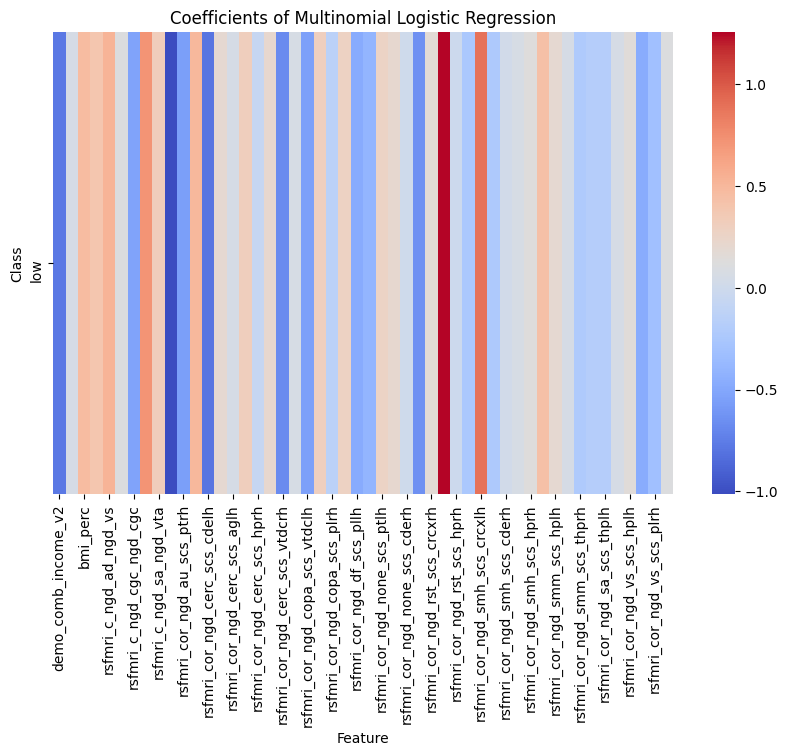

In [303]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

In [304]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_test_reg_sm = sm.add_constant(X_testReg)


/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [305]:
X_test_reg_sm.shape

(232, 51)

In [306]:
y_testReg

1034    1
555     1
2743    0
2008    0
1011    1
       ..
1422    1
3004    0
3688    0
240     1
43      1
Name: ssb_group, Length: 232, dtype: int64

In [307]:
y_testReg = y_testReg.replace({2:1})

In [312]:
X_test_reg_sm

,demo_comb_income_v2,interview_age,bmi_perc,sex_M,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_cgc_ngd_ad,rsfmri_c_ngd_cgc_ngd_cgc,rsfmri_c_ngd_smh_ngd_smm,rsfmri_c_ngd_sa_ngd_vta,rsfmri_cor_ngd_au_scs_aalh,...,rsfmri_cor_ngd_smm_scs_hplh,rsfmri_cor_ngd_smm_scs_aglh,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_crcxlh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_vta_scs_hplh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh
1034,1.134865,2.208108,0.044800,0,-0.027387,0.060583,0.062124,0.022836,-0.028717,-0.191527,...,-0.050664,-0.105029,0.025476,-0.101897,0.062144,-0.043374,-0.142328,0.036753,-0.144606,0.001409
555,1.134865,9.208108,-0.189872,1,-0.052557,-0.054117,-0.073468,-0.014154,-0.114750,0.056176,...,-0.047270,0.002918,0.100933,-0.027376,0.118380,0.033815,0.118307,-0.012432,0.025928,0.036245
2743,-0.865135,-7.791892,0.113433,0,0.055490,-0.107494,-0.052150,-0.196300,-0.017239,-0.040469,...,0.148725,-0.047079,0.028939,-0.015646,0.047023,0.124734,0.107247,-0.078499,-0.040466,0.189448
2008,1.134865,-9.791892,0.103893,1,-0.062460,-0.043192,0.001967,0.000891,0.049589,0.074604,...,-0.094273,0.040634,0.019857,-0.050628,0.049566,-0.101703,0.036462,0.042495,-0.029691,0.082267
1011,1.134865,10.208108,-0.156223,0,-0.027302,0.013445,0.077198,-0.142891,-0.034331,0.119778,...,-0.063710,0.197938,-0.012236,-0.031879,0.102747,-0.163819,-0.003733,-0.014703,-0.050859,0.121057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,-4.865135,10.208108,0.367691,1,0.192097,-0.034494,0.001720,0.228986,-0.043851,-0.116817,...,-0.047182,-0.101878,-0.007012,0.026734,-0.113596,0.186760,-0.050435,0.083714,-0.059599,-0.170908
3004,0.134865,-9.791892,0.282854,0,0.030097,0.040278,0.087624,0.020171,-0.062701,0.077558,...,0.185971,-0.131622,0.064322,0.133650,0.005851,0.003069,0.046679,0.003207,0.121480,0.017764
3688,2.134865,4.208108,-0.547327,1,-0.035580,-0.047370,0.067402,0.019499,-0.002403,0.030842,...,0.001656,0.061568,0.015535,-0.036554,-0.124350,-0.086498,-0.021002,0.030753,0.010294,-0.072128
240,-1.865135,-8.791892,0.391244,1,0.043231,-0.076530,-0.071088,0.010631,-0.087915,-0.048065,...,0.080671,-0.108169,-0.106584,-0.011966,-0.125226,-0.080085,-0.082665,0.027971,0.078344,0.011995


In [308]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm)
result = logit_model.fit()
#model_sm = sm.MNLogit(y_testReg, X_test_reg_sm)
#result_sm = model_sm.fit(method='newton', maxiter=5000)


Optimization terminated successfully.
         Current function value: 0.428155
         Iterations 8


In [309]:
# Summary of the model
# print(result_sm.summary())
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  232
Model:                          Logit   Df Residuals:                      181
Method:                           MLE   Df Model:                           50
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.3820
Time:                        17:04:00   Log-Likelihood:                -99.332
converged:                       True   LL-Null:                       -160.73
Covariance Type:            nonrobust   LLR p-value:                 4.634e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0565      0.312     -0.181      0.856      -0.667       0.554
demo_comb_income_v2               -0.9949      0.205     -4.856      0.

rsfmri_cor_ngd_cerc_scs_vtdcrh


In [310]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_test_reg_sm = X_test_reg_sm.drop('const', axis=1, errors='ignore')
# Assuming X_test_reg_sm is a DataFrame containing your independent variables
# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X_test_reg_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_test_reg_sm.values, i)
                   for i in range(X_test_reg_sm.shape[1])]

## High colinearity 

rsfmri_cor_ngd_smh_scs_aarh  12.032336 sensorimotor hand network and ASEG ROI right-accumbens-area
rsfmri_cor_ngd_smm_scs_hplh  10.607078 sensorimotor mouth network and ASEG ROI left-hippocampus
rsfmri_cor_ngd_smh_scs_cderh  12.081220 sensorimotor hand network and ASEG ROI right-caudate
rsfmri_cor_ngd_smh_scs_pllh  14.114441 sensorimotor hand network and ASEG ROI left-pallidum
rsfmri_cor_ngd_cerc_scs_hprh  13.998296 cingulo-opercular network and ASEG ROI right-hippocampus
rsfmri_cor_ngd_cerc_scs_aglh  12.118315 cingulo-opercular network and ASEG ROI left-amygdala
rsfmri_cor_ngd_copa_scs_thplh  10.300751 cingulo-parietal network and ASEG ROI left-thalamus-proper

In [313]:
X_test_reg_sm

,demo_comb_income_v2,interview_age,bmi_perc,sex_M,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_cgc_ngd_ad,rsfmri_c_ngd_cgc_ngd_cgc,rsfmri_c_ngd_smh_ngd_smm,rsfmri_c_ngd_sa_ngd_vta,rsfmri_cor_ngd_au_scs_aalh,...,rsfmri_cor_ngd_smm_scs_hplh,rsfmri_cor_ngd_smm_scs_aglh,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_crcxlh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_vta_scs_hplh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh
1034,1.134865,2.208108,0.044800,0,-0.027387,0.060583,0.062124,0.022836,-0.028717,-0.191527,...,-0.050664,-0.105029,0.025476,-0.101897,0.062144,-0.043374,-0.142328,0.036753,-0.144606,0.001409
555,1.134865,9.208108,-0.189872,1,-0.052557,-0.054117,-0.073468,-0.014154,-0.114750,0.056176,...,-0.047270,0.002918,0.100933,-0.027376,0.118380,0.033815,0.118307,-0.012432,0.025928,0.036245
2743,-0.865135,-7.791892,0.113433,0,0.055490,-0.107494,-0.052150,-0.196300,-0.017239,-0.040469,...,0.148725,-0.047079,0.028939,-0.015646,0.047023,0.124734,0.107247,-0.078499,-0.040466,0.189448
2008,1.134865,-9.791892,0.103893,1,-0.062460,-0.043192,0.001967,0.000891,0.049589,0.074604,...,-0.094273,0.040634,0.019857,-0.050628,0.049566,-0.101703,0.036462,0.042495,-0.029691,0.082267
1011,1.134865,10.208108,-0.156223,0,-0.027302,0.013445,0.077198,-0.142891,-0.034331,0.119778,...,-0.063710,0.197938,-0.012236,-0.031879,0.102747,-0.163819,-0.003733,-0.014703,-0.050859,0.121057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,-4.865135,10.208108,0.367691,1,0.192097,-0.034494,0.001720,0.228986,-0.043851,-0.116817,...,-0.047182,-0.101878,-0.007012,0.026734,-0.113596,0.186760,-0.050435,0.083714,-0.059599,-0.170908
3004,0.134865,-9.791892,0.282854,0,0.030097,0.040278,0.087624,0.020171,-0.062701,0.077558,...,0.185971,-0.131622,0.064322,0.133650,0.005851,0.003069,0.046679,0.003207,0.121480,0.017764
3688,2.134865,4.208108,-0.547327,1,-0.035580,-0.047370,0.067402,0.019499,-0.002403,0.030842,...,0.001656,0.061568,0.015535,-0.036554,-0.124350,-0.086498,-0.021002,0.030753,0.010294,-0.072128
240,-1.865135,-8.791892,0.391244,1,0.043231,-0.076530,-0.071088,0.010631,-0.087915,-0.048065,...,0.080671,-0.108169,-0.106584,-0.011966,-0.125226,-0.080085,-0.082665,0.027971,0.078344,0.011995


In [317]:
## Test dropping rsfmri_cor_ngd_smh_scs_pllh (higheest colinearity)
X_test_reg_sm_nopllh = X_test_reg_sm.drop(columns=['rsfmri_cor_ngd_smh_scs_pllh'])

# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm_nopllh)
result = logit_model.fit()

X_test_reg_sm_nopllh = X_test_reg_sm_nopllh.drop('const', axis=1, errors='ignore')
# Assuming X_test_reg_sm is a DataFrame containing your independent variables
# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X_test_reg_sm_nopllh.columns
vif_data["VIF"] = [variance_inflation_factor(X_test_reg_sm_nopllh.values, i)
                   for i in range(X_test_reg_sm_nopllh.shape[1])]
print(vif_data)

Optimization terminated successfully.
         Current function value: 0.428379
         Iterations 8
                           feature        VIF
0              demo_comb_income_v2   1.647836
1                    interview_age   1.262591
2                         bmi_perc   1.305986
3                            sex_M   1.316779
4           rsfmri_c_ngd_ad_ngd_vs   1.946340
5          rsfmri_c_ngd_cgc_ngd_ad   3.342269
6         rsfmri_c_ngd_cgc_ngd_cgc   2.674093
7         rsfmri_c_ngd_smh_ngd_smm   2.470313
8          rsfmri_c_ngd_sa_ngd_vta   2.019671
9       rsfmri_cor_ngd_au_scs_aalh   3.728423
10      rsfmri_cor_ngd_au_scs_ptrh   7.265946
11    rsfmri_cor_ngd_au_scs_vtdcrh   2.438948
12   rsfmri_cor_ngd_cerc_scs_cdelh   5.794385
13    rsfmri_cor_ngd_cerc_scs_ptlh   5.491006
14    rsfmri_cor_ngd_cerc_scs_aglh   6.038260
15  rsfmri_cor_ngd_cerc_scs_vtdclh   1.540567
16    rsfmri_cor_ngd_cerc_scs_hprh  13.388243
17    rsfmri_cor_ngd_cerc_scs_agrh   7.844750
18  rsfmri_cor_ngd_cerc_

16    rsfmri_cor_ngd_cerc_scs_hprh  13.388243 cingulo-opercular network and ASEG ROI right-hippocampus
19   rsfmri_cor_ngd_copa_scs_thplh  10.231952 cingulo-parietal network and ASEG ROI left-thalamus-proper
38     rsfmri_cor_ngd_smh_scs_aarh  11.725803 sensorimotor hand network and ASEG ROI right-accumbens-area
39     rsfmri_cor_ngd_smm_scs_hplh  10.601118 sensorimotor mouth network and ASEG ROI left-hippocampus	

In [319]:
## Test dropping rsfmri_cor_ngd_smh_scs_pllh (higheest colinearity)
## and rsfmri_cor_ngd_cerc_scs_hprh 
X_test_reg_sm_nopllh = X_test_reg_sm.drop(columns=['rsfmri_cor_ngd_smh_scs_pllh','rsfmri_cor_ngd_cerc_scs_hprh'])

# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm_nopllh)
result = logit_model.fit()

X_test_reg_sm_nopllh = X_test_reg_sm_nopllh.drop('const', axis=1, errors='ignore')
# Assuming X_test_reg_sm is a DataFrame containing your independent variables
# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X_test_reg_sm_nopllh.columns
vif_data["VIF"] = [variance_inflation_factor(X_test_reg_sm_nopllh.values, i)
                   for i in range(X_test_reg_sm_nopllh.shape[1])]
print(vif_data)

Optimization terminated successfully.
         Current function value: 0.430073
         Iterations 8
                           feature        VIF
0              demo_comb_income_v2   1.647183
1                    interview_age   1.250120
2                         bmi_perc   1.302619
3                            sex_M   1.295677
4           rsfmri_c_ngd_ad_ngd_vs   1.937135
5          rsfmri_c_ngd_cgc_ngd_ad   3.304198
6         rsfmri_c_ngd_cgc_ngd_cgc   2.663257
7         rsfmri_c_ngd_smh_ngd_smm   2.345091
8          rsfmri_c_ngd_sa_ngd_vta   2.019317
9       rsfmri_cor_ngd_au_scs_aalh   3.440102
10      rsfmri_cor_ngd_au_scs_ptrh   7.214229
11    rsfmri_cor_ngd_au_scs_vtdcrh   2.412868
12   rsfmri_cor_ngd_cerc_scs_cdelh   5.294633
13    rsfmri_cor_ngd_cerc_scs_ptlh   5.490053
14    rsfmri_cor_ngd_cerc_scs_aglh   5.065025
15  rsfmri_cor_ngd_cerc_scs_vtdclh   1.520302
16    rsfmri_cor_ngd_cerc_scs_agrh   7.755925
17  rsfmri_cor_ngd_cerc_scs_vtdcrh   5.852870
18   rsfmri_cor_ngd_copa

37     rsfmri_cor_ngd_smh_scs_aarh  11.666665 sensorimotor hand network and ASEG ROI right-accumbens-area
38     rsfmri_cor_ngd_smm_scs_hplh  10.577840 sensorimotor mouth network and ASEG ROI left-hippocampus	


In [320]:
## Test dropping rsfmri_cor_ngd_smh_scs_pllh (higheest colinearity)
## and rsfmri_cor_ngd_cerc_scs_hprh 
## and rsfmri_cor_ngd_smh_scs_aarh
X_test_reg_sm_nopllh = X_test_reg_sm.drop(columns=['rsfmri_cor_ngd_smh_scs_pllh','rsfmri_cor_ngd_cerc_scs_hprh','rsfmri_cor_ngd_smh_scs_aarh'])

# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm_nopllh)
result = logit_model.fit()

X_test_reg_sm_nopllh = X_test_reg_sm_nopllh.drop('const', axis=1, errors='ignore')
# Assuming X_test_reg_sm is a DataFrame containing your independent variables
# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X_test_reg_sm_nopllh.columns
vif_data["VIF"] = [variance_inflation_factor(X_test_reg_sm_nopllh.values, i)
                   for i in range(X_test_reg_sm_nopllh.shape[1])]
print(vif_data)

Optimization terminated successfully.
         Current function value: 0.430739
         Iterations 8
                           feature       VIF
0              demo_comb_income_v2  1.644417
1                    interview_age  1.235886
2                         bmi_perc  1.302563
3                            sex_M  1.288477
4           rsfmri_c_ngd_ad_ngd_vs  1.937129
5          rsfmri_c_ngd_cgc_ngd_ad  3.205271
6         rsfmri_c_ngd_cgc_ngd_cgc  2.649180
7         rsfmri_c_ngd_smh_ngd_smm  2.334715
8          rsfmri_c_ngd_sa_ngd_vta  2.012095
9       rsfmri_cor_ngd_au_scs_aalh  3.437451
10      rsfmri_cor_ngd_au_scs_ptrh  7.166069
11    rsfmri_cor_ngd_au_scs_vtdcrh  2.381450
12   rsfmri_cor_ngd_cerc_scs_cdelh  5.133338
13    rsfmri_cor_ngd_cerc_scs_ptlh  5.486766
14    rsfmri_cor_ngd_cerc_scs_aglh  5.041576
15  rsfmri_cor_ngd_cerc_scs_vtdclh  1.501413
16    rsfmri_cor_ngd_cerc_scs_agrh  7.754648
17  rsfmri_cor_ngd_cerc_scs_vtdcrh  5.837638
18   rsfmri_cor_ngd_copa_scs_thplh  5.47045

In [321]:
# Summary of the model with low colinearity 
# print(result_sm.summary())
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  232
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                           46
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.3783
Time:                        17:16:52   Log-Likelihood:                -99.931
converged:                       True   LL-Null:                       -160.73
Covariance Type:            nonrobust   LLR p-value:                 9.526e-09
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
demo_comb_income_v2               -0.9927      0.194     -5.124      0.000      -1.372      -0.613
interview_age                      0.0279      0.028      0.994      0.

In [322]:
# Making predictions
predictions = result.predict(X_test_reg_sm_nopllh)

# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)

In [323]:
predictions

1034    0.180617
555     0.744186
2743    0.080734
2008    0.165142
1011    0.186868
          ...   
1422    0.998239
3004    0.724180
3688    0.052870
240     0.950724
43      0.699079
Length: 232, dtype: float64

In [324]:
class_predictions

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [325]:
array = y_testReg.to_numpy()

In [326]:
dfPrevReal = pd.DataFrame({'real': array, 'pred': class_predictions})

In [327]:
dfPrevReal

,real,pred
0,1,0
1,1,1
2,0,0
3,0,0
4,1,0
...,...,...
227,1,1
228,0,1
229,0,0
230,1,1


In [328]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)


Jaccard Similarity Score: 0.627906976744186


In [329]:
# Extract p-values for all coefficients in the model
p_values = result.pvalues

In [330]:
result.pvalues

demo_comb_income_v2               2.991718e-07
interview_age                     3.203034e-01
bmi_perc                          8.238896e-02
sex_M                             1.225937e-01
rsfmri_c_ngd_ad_ngd_vs            8.612840e-01
rsfmri_c_ngd_cgc_ngd_ad           5.202079e-01
rsfmri_c_ngd_cgc_ngd_cgc          2.281562e-01
rsfmri_c_ngd_smh_ngd_smm          6.592486e-01
rsfmri_c_ngd_sa_ngd_vta           5.606709e-01
rsfmri_cor_ngd_au_scs_aalh        1.232151e-01
rsfmri_cor_ngd_au_scs_ptrh        8.065185e-01
rsfmri_cor_ngd_au_scs_vtdcrh      3.585146e-01
rsfmri_cor_ngd_cerc_scs_cdelh     1.919107e-01
rsfmri_cor_ngd_cerc_scs_ptlh      6.291032e-01
rsfmri_cor_ngd_cerc_scs_aglh      5.242503e-01
rsfmri_cor_ngd_cerc_scs_vtdclh    3.926915e-01
rsfmri_cor_ngd_cerc_scs_agrh      5.874442e-01
rsfmri_cor_ngd_cerc_scs_vtdcrh    1.882711e-01
rsfmri_cor_ngd_copa_scs_thplh     5.802909e-01
rsfmri_cor_ngd_copa_scs_vtdclh    2.569139e-02
rsfmri_cor_ngd_copa_scs_crcxrh    7.725150e-01
rsfmri_cor_ng

In [331]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')

# Reshape the corrected p-values to match the original shape
pvals_corrected_reshaped = pvals_corrected.reshape(p_values.shape)

# Create a DataFrame of the corrected p-values for easier interpretation
# corrected_pvalues_df = pd.DataFrame(pvals_corrected_reshaped, index=p_values.index, columns=p_values.columns)

In [332]:
pvals_corrected_reshaped

array([1.40610744e-05, 8.55699372e-01, 6.59698168e-01, 6.59698168e-01,
       9.59184599e-01, 8.55699372e-01, 8.24872314e-01, 8.60685685e-01,
       8.55699372e-01, 6.59698168e-01, 9.47380567e-01, 8.55699372e-01,
       8.19982198e-01, 8.55699372e-01, 8.55699372e-01, 8.55699372e-01,
       8.55699372e-01, 8.19982198e-01, 8.55699372e-01, 4.02498519e-01,
       9.30979652e-01, 8.55699372e-01, 8.55699372e-01, 8.55699372e-01,
       6.59698168e-01, 8.78905295e-01, 8.24872314e-01, 8.55699372e-01,
       4.02498519e-01, 9.30979652e-01, 8.55699372e-01, 9.97247370e-01,
       8.55699372e-01, 9.97247370e-01, 8.55699372e-01, 8.55699372e-01,
       8.55699372e-01, 6.59698168e-01, 9.59184599e-01, 9.82954590e-01,
       9.47380567e-01, 8.55699372e-01, 8.55699372e-01, 6.59698168e-01,
       8.55699372e-01, 8.55699372e-01, 9.65673505e-01])

# Notes
Have too many features per sample/group. Will need to do dimensionaity reduction to get ~ 50 features per 500 subjects

## Reminder
matrix = sub,row,col